# Import necessary depencencies

In [1]:
import pandas as pd
import numpy as np
import text_normalizer as tn
import model_evaluation_utils as meu
import pydot

np.set_printoptions(precision=2, linewidth=80)

# Load and normalize data

In [2]:
dataset = pd.read_csv(r'movie_reviews_cleaned.csv')
# take a peek at the data
print(dataset.head())
reviews = np.array(dataset['review'])
sentiments = np.array(dataset['sentiment'])

# build train and test datasets
norm_train_reviews = reviews[:35000]
norm_train_sentiments = sentiments[:35000]
norm_test_reviews = reviews[35000:]
norm_test_sentiments = sentiments[35000:]

                                              review sentiment
0  not bother think would see movie great supspen...  negative
1  careful one get mitt change way look kung fu f...  positive
2  chili palmer tired movie know want success mus...  negative
3  follow little know 1998 british film make budg...  positive
4  dark angel cross huxley brave new world percys...  positive


# Tokenize train & test datasets

In [3]:
tokenized_train = [tn.tokenizer.tokenize(text) for text in norm_train_reviews]
tokenized_test = [tn.tokenizer.tokenize(text) for text in norm_test_reviews]

# Build Vocabulary Mapping (word to index)

In [4]:
from collections import Counter

# build word to index vocabulary
token_counter = Counter([token for review in tokenized_train for token in review])
vocab_map = {item[0]: index+1 for index, item in enumerate(dict(token_counter).items())}
max_index = np.max(list(vocab_map.values()))
vocab_map['PAD_INDEX'] = 0
vocab_map['NOT_FOUND_INDEX'] = max_index+1
vocab_size = len(vocab_map)
# view vocabulary size and part of the vocabulary map
print('Vocabulary Size:', vocab_size)
print('Sample slice of vocabulary map:', dict(list(vocab_map.items())[10:20]))

Vocabulary Size: 80004
Sample slice of vocabulary map: {'boring': 11, 'terribly': 12, 'predictable': 13, 'interesting': 14, 'start': 15, 'middle': 16, 'film': 17, 'little': 18, 'social': 19, 'drama': 20}


# Encode and Pad datasets & Encode prediction class labels

In [5]:
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

# get max length of train corpus and initialize label encoder
le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0
max_len = np.max([len(review) for review in tokenized_train])

## Train reviews data corpus
# Convert tokenized text reviews to numeric vectors
train_X = [[vocab_map[token] for token in tokenized_review] for tokenized_review in tokenized_train]
train_X = sequence.pad_sequences(train_X, maxlen=max_len) # pad 
## Train prediction class labels
# Convert text sentiment labels (negative\positive) to binary encodings (0/1)
train_y = le.fit_transform(norm_train_sentiments)

## Test reviews data corpus
# Convert tokenized text reviews to numeric vectors
test_X = [[vocab_map[token] if vocab_map.get(token) else vocab_map['NOT_FOUND_INDEX'] 
           for token in tokenized_review] 
              for tokenized_review in tokenized_test]
test_X = sequence.pad_sequences(test_X, maxlen=max_len)
## Test prediction class labels
# Convert text sentiment labels (negative\positive) to binary encodings (0/1)
test_y = le.transform(norm_test_sentiments)

# view vector shapes
print('Max length of train review vectors:', max_len)
print('Train review vectors shape:', train_X.shape, ' Test review vectors shape:', test_X.shape)

Using TensorFlow backend.


Max length of train review vectors: 1115
Train review vectors shape: (35000, 1115)  Test review vectors shape: (15000, 1115)


# Build the LSTM Model Architecture

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, SpatialDropout1D
from keras.layers import LSTM

EMBEDDING_DIM = 128 # dimension for dense embeddings for each token
LSTM_DIM = 64 # total LSTM units

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(LSTM_DIM, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

In [7]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1115, 128)         10240512  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 1115, 128)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 10,289,985
Trainable params: 10,289,985
Non-trainable params: 0
_________________________________________________________________
None


# Visualize model architecture

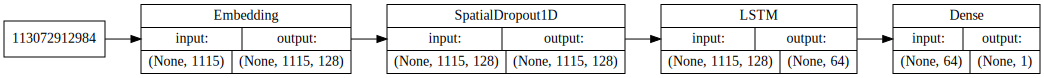

In [9]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
                 rankdir='LR').create(prog='dot', format='svg'))

# Train the model

In [10]:
batch_size = 100
model.fit(train_X, train_y, epochs=5, batch_size=batch_size, 
          shuffle=True, validation_split=0.1, verbose=1)

Train on 31500 samples, validate on 3500 samples
Epoch 1/5
31500/31500 [==============================] - 476s 15ms/step - loss: 0.4036 - acc: 0.8192 - val_loss: 0.2964 - val_acc: 0.8846
Epoch 2/5
31500/31500 [==============================] - 479s 15ms/step - loss: 0.2226 - acc: 0.9157 - val_loss: 0.2889 - val_acc: 0.8926
Epoch 3/5
31500/31500 [==============================] - 474s 15ms/step - loss: 0.1477 - acc: 0.9487 - val_loss: 0.3240 - val_acc: 0.8794
Epoch 4/5
31500/31500 [==============================] - 462s 15ms/step - loss: 0.0991 - acc: 0.9660 - val_loss: 0.3402 - val_acc: 0.8857
Epoch 5/5
31500/31500 [==============================] - 471s 15ms/step - loss: 0.0896 - acc: 0.9697 - val_loss: 0.4066 - val_acc: 0.8857


# Predict and Evaluate Model Performance

In [11]:
pred_test = model.predict_classes(test_X)
predictions = le.inverse_transform(pred_test.flatten())

/Users/james/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [13]:
meu.display_model_performance_metrics(true_labels=norm_test_sentiments, predicted_labels=predictions, 
                                      classes=['positive', 'negative'])  

Model Performance metrics:
------------------------------
Accuracy: 0.8752
Precision: 0.8755
Recall: 0.8752
F1 Score: 0.8752

Model Classification report:
------------------------------
             precision    recall  f1-score   support

   positive       0.87      0.89      0.88      7587
   negative       0.88      0.86      0.87      7413

avg / total       0.88      0.88      0.88     15000


Prediction Confusion Matrix:
------------------------------
                 Predicted:         
                   positive negative
Actual: positive       6759      828
        negative       1044     6369
